In [59]:
import pandas as pd

#loading the data from the csv file and converting it in to data frame 
file_path = 'Rogers_022824.csv'

# Reading the CSV file
rogers_data = pd.read_csv(file_path)


num_rows = rogers_data.shape[0]
# Print the result
print(f"Number of rows in rogers_data: {num_rows}")


Number of rows in rogers_data: 4644


In [60]:
#Q1 
# Convert the 'purchase_datetime' column to datetime format 
rogers_data['purchase_datetime'] = pd.to_datetime(rogers_data['purchase_datetime'])

# Calculate the entry time by subtracting 'trip_duration_mins' from 'purchase_datetime'
rogers_data['entry_time'] = rogers_data['purchase_datetime'] - pd.to_timedelta(rogers_data['trip_duration_mins'], unit='m')

# Display the first few rows of the calculated entry times
print(rogers_data[['purchase_datetime', 'trip_duration_mins', 'entry_time']].head())
 
# Drop duplicate session_id to ensure each group is counted only once
unique_sessions = rogers_data.drop_duplicates(subset='session_id')

    purchase_datetime  trip_duration_mins              entry_time
0 2024-02-28 07:03:00              1.0666 2024-02-28 07:01:56.004
1 2024-02-28 07:03:00              1.0666 2024-02-28 07:01:56.004
2 2024-02-28 07:03:00              1.0666 2024-02-28 07:01:56.004
3 2024-02-28 07:09:00              0.9500 2024-02-28 07:08:03.000
4 2024-02-28 07:09:00              0.8500 2024-02-28 07:08:09.000


Total number of unique customers entered between 7:00 AM and 11:00 PM: 2372
      entry_time_15min  group_size
0  2024-02-28 07:00:00           3
1  2024-02-28 07:15:00           7
2  2024-02-28 07:30:00          13
3  2024-02-28 07:45:00           8
4  2024-02-28 08:00:00          18
..                 ...         ...
59 2024-02-28 21:45:00          41
60 2024-02-28 22:00:00          40
61 2024-02-28 22:15:00          45
62 2024-02-28 22:30:00          49
63 2024-02-28 22:45:00          39

[64 rows x 2 columns]


/tmp/ipykernel_5035/758395655.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_sessions['leave_time'] = unique_sessions['entry_time'] + pd.to_timedelta(unique_sessions['trip_duration_mins'], unit='m')
/tmp/ipykernel_5035/758395655.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_sessions['entry_time_15min'] = unique_sessions['entry_time'].dt.floor('15min')
/tmp/ipykernel_5035/758395655.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

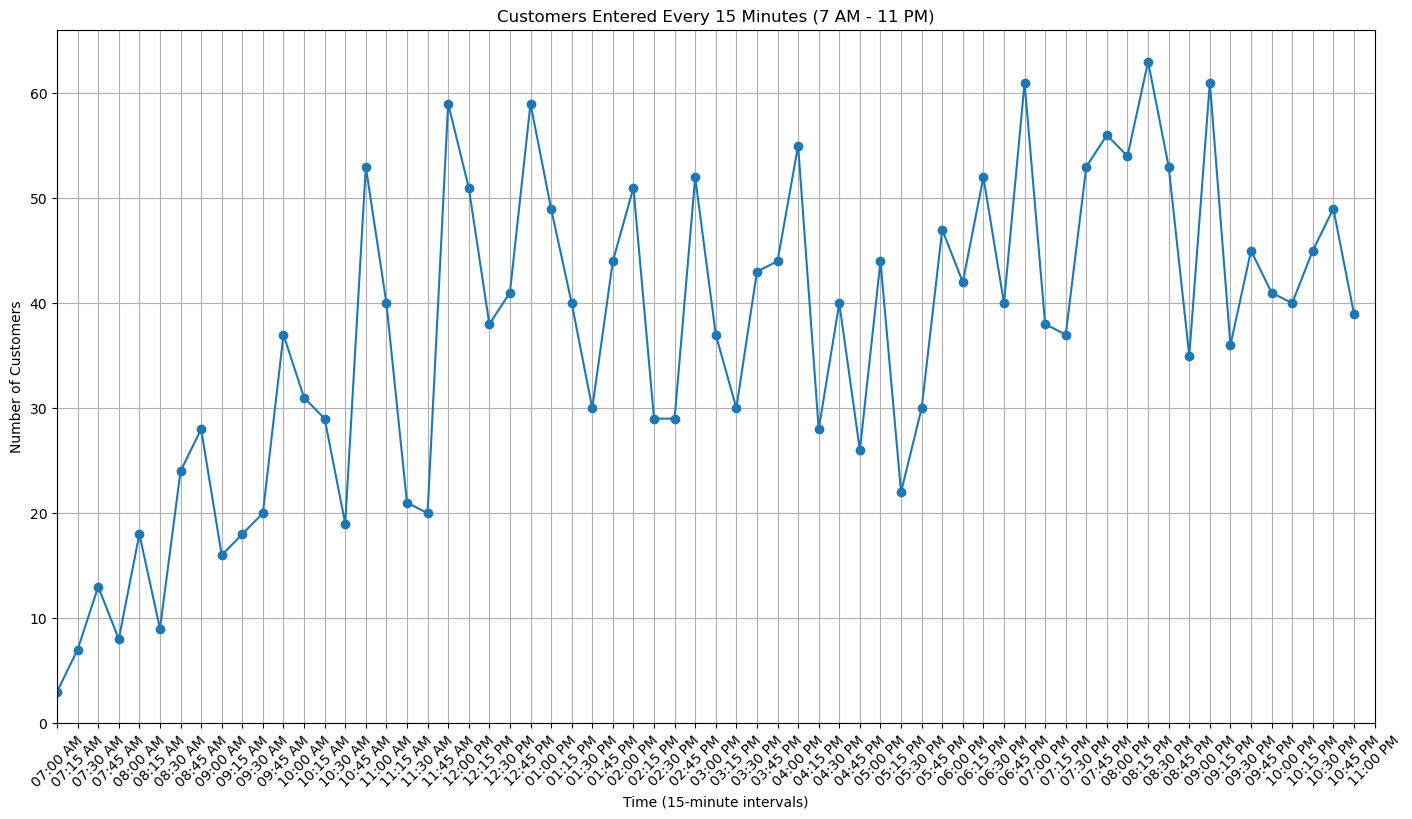

In [61]:

# Filter for time between 7AM and 11PM 

# Define the start and end time for filtering (from 7AM to 11PM)
start_time = pd.Timestamp('2024-02-28 07:00:00')
end_time = pd.Timestamp('2024-02-28 23:00:00')
filtered_data = unique_sessions[(unique_sessions['entry_time'] >= start_time) & (unique_sessions['entry_time'] <= end_time)]

# Calculate the total number of customers 
total_customers = unique_sessions['group_size'].sum()
print(f"Total number of unique customers entered between 7:00 AM and 11:00 PM: {total_customers}")


# Calculate 'leave_time' (when customers exit the store)
unique_sessions['leave_time'] = unique_sessions['entry_time'] + pd.to_timedelta(unique_sessions['trip_duration_mins'], unit='m')

# Round 'entry_time' and 'leave_time' to the nearest 15-minute intervals
unique_sessions['entry_time_15min'] = unique_sessions['entry_time'].dt.floor('15min')
unique_sessions['leave_time_15min'] = unique_sessions['leave_time'].dt.floor('15min')

# Calculate customers entering at each 15-minute interval
customers_entered = unique_sessions.groupby('entry_time_15min')['group_size'].sum().reset_index()
print(customers_entered)

# Calculate customers leaving at each 15-minute interval
customers_left = unique_sessions.groupby('leave_time_15min')['group_size'].sum().reset_index()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting customers entered every 15 minutes
plt.figure(figsize=(17,9))
plt.plot(customers_entered['entry_time_15min'], customers_entered['group_size'], marker='o')
plt.title('Customers Entered Every 15 Minutes (7 AM - 11 PM)')
plt.xlabel('Time (15-minute intervals)')
plt.ylabel('Number of Customers')

# Formatting the x-axis to show 15-minute intervals with appropriate time format
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))  # Set interval to 15 minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%I:%M %p'))  # Format x-axis as "Hour:Minute AM/PM"

# Set x-axis limits to ensure it starts from 7:00 AM
plt.xlim([start_time, end_time])

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the grid and the plot
plt.grid(True)
plt.show()


In [62]:
# Calculate customers per hour
customers_per_hour = unique_sessions.set_index('entry_time').resample('H')['group_size'].sum()
average_customers_per_hour = customers_per_hour.mean()

# Print the average number of customers per minute
print(f"Average number of customers per hour: {average_customers_per_hour}")


Average number of customers per hour: 148.25


/tmp/ipykernel_5035/1130849675.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  customers_per_hour = unique_sessions.set_index('entry_time').resample('H')['group_size'].sum()


In [63]:
#q-2  
weighted_avg_trip_duration = ( unique_sessions['trip_duration_mins'] *  unique_sessions['group_size']).sum() /  unique_sessions['group_size'].sum()
print(f"Average flow time of a customer: {weighted_avg_trip_duration:.2f} minutes")

# Calculate customers per minute
customers_per_minute = unique_sessions.set_index('entry_time').resample('T')['group_size'].sum()
average_customers_per_minute = customers_per_minute.mean()
print(f"Average number of customers per minute: {average_customers_per_minute}")

Average flow time of a customer: 2.11 minutes
Average number of customers per minute: 2.481171548117155


/tmp/ipykernel_5035/1534593780.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  customers_per_minute = unique_sessions.set_index('entry_time').resample('T')['group_size'].sum()


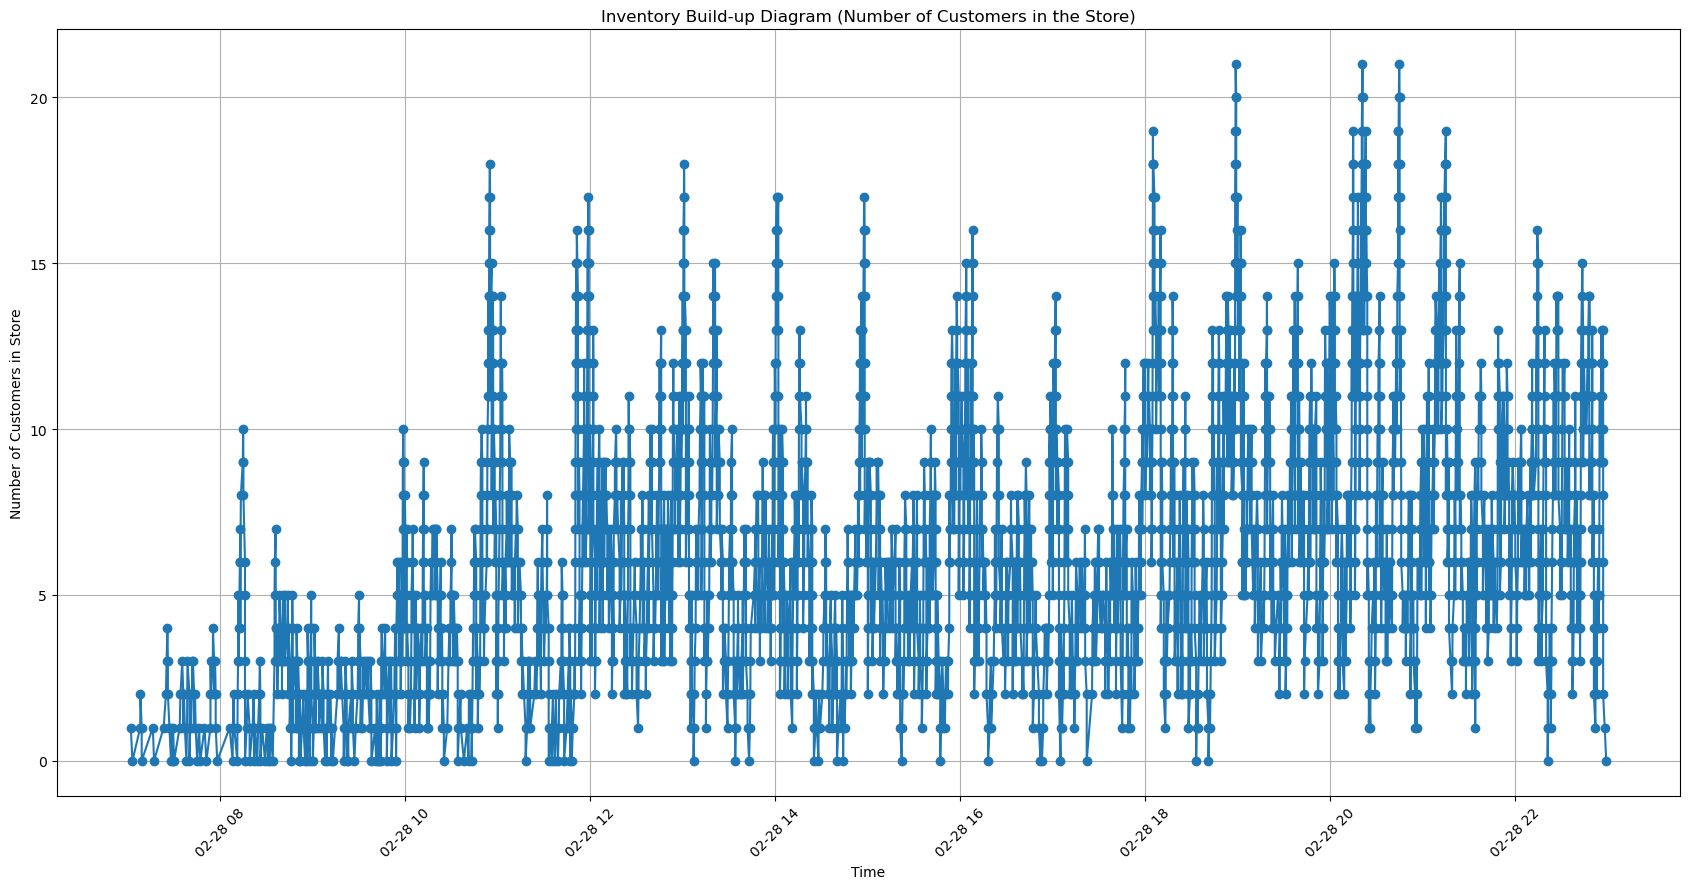

In [64]:
# Q3 is the inventory build up diagram
#calculating inventory
inventory_events = pd.DataFrame({
    'datetime': pd.concat([unique_sessions['entry_time'], unique_sessions['purchase_datetime']]),
    'event': pd.concat([unique_sessions['group_size'], -unique_sessions['group_size']])
})

# Sort events by time
inventory_events = inventory_events.sort_values('datetime')

# Calculate cumulative sum of events to get the number of customers in the store over time
inventory_events['inventory'] = inventory_events['event'].cumsum()

# Plotting the Inventory Build-up over time
plt.figure(figsize=(17,9))
# Plot the inventory build-up over time
plt.plot(inventory_events['datetime'], inventory_events['inventory'], marker='o')
plt.title('Inventory Build-up Diagram (Number of Customers in the Store)')
plt.xlabel('Time')
plt.ylabel('Number of Customers in Store')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Q-4 calculating inventory from the inventory build up diagram
from numpy import trapz 
time_in_seconds = (inventory_events['datetime'] - inventory_events['datetime'].min()).dt.total_seconds()

# Use the trapezoidal rule to calculate area under the curve (inventory over time)
area_under_curve = trapz(inventory_events['inventory'], time_in_seconds)

# Total time in hours (from the first to the last time)
total_time_in_hours = (inventory_events['datetime'].max() - inventory_events['datetime'].min()).total_seconds() / 3600

# Calculate the average inventory using the formula: area under curve / total time
average_inventory = area_under_curve / (total_time_in_hours * 3600)  # Convert back to correct unit
# Print the result
print(f"Total area under the curve (customer time): {area_under_curve:.2f} customer-seconds")
print(f"Total time (hours): {total_time_in_hours:.2f} hours")
print(f"Average inventory (average customers in store): {average_inventory:.2f} customers")


Total area under the curve (customer time): 308401.81 customer-seconds
Total time (hours): 15.95 hours
Average inventory (average customers in store): 5.37 customers


In [66]:
# using littles law 
Inventory = average_customers_per_minute * weighted_avg_trip_duration

print(f"Inventory using littles law : {Inventory:.2f} customers")

Inventory using littles law : 5.22 customers
